## Tsunami runup example

Validation of the AnuGA implementation of the shallow water wave equation.
This script sets up Okushiri Island benchmark as published at the
[Third International Workshop on Long-Wave Runup Models](http://isec.nacse.org/workshop/2004_cornell/background.html).

The validation data is available from our [anuga-clinic](https://github.com/anuga-community/anuga-clinic) repository and the original data is available
[online](http://isec.nacse.org/workshop/2004_cornell/bmark2.html)
where a detailed description of the problem is also available.

### Setup Notebook for Visualisation and Animation

We are using the format of a jupyter notebook. As such we need to setup inline matplotlib plotting and animation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

### Import ANUGA

We assume that anuga has been installed. If so we can import anuga. 

In [2]:
import anuga

### The Code 

This code is taken from [run_okishuri.py](https://github.com/anuga-community/anuga_core/blob/main/validation_tests/experimental_data/okushiri/run_okushiri.py).

First we define the location of our data files, which specify:

   (1) the incoming tsunami wave, 
   
   (2) the bathymetry file, 
   
   (3) the measured stage height at 3 gauge locations.

In [3]:
# Incoming boundary wave (m)
boundary_filename = '/home/steve/anuga-clinic/data/Okushiri/Benchmark_2_input.txt'

# Digital Elevation Model (x,y,z) (m)
bathymetry_filename = '/home/steve/anuga-clinic/data/Okushiri/Benchmark_2_Bathymetry.xya'

# Observed timeseries (cm)
gauge_filename = '/home/steve/anuga-clinic/data/Okushiri/output_ch5-7-9.txt'

### Load Barthymetry Data

Using in the barthymetry data provided from the workshop. We need to reshape the data and form a raster (x,y,Z).

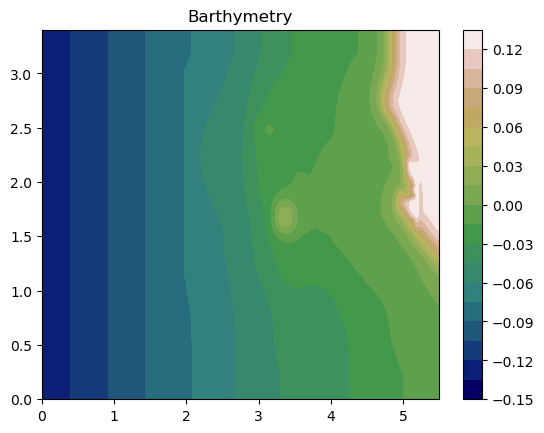

In [4]:
xya = np.loadtxt(bathymetry_filename, skiprows=1, delimiter=',')
  
X = xya[:,0].reshape(393,244)
Y = xya[:,1].reshape(393,244)
Z = xya[:,2].reshape(393,244)


plt.contourf(X,Y,Z, 20, cmap=plt.get_cmap('gist_earth'));
plt.title('Barthymetry')
plt.colorbar();

# Create raster tuple
x = X[:,0]
y = Y[0,:]
Zr = np.flipud(Z.T)

raster = x,y,Zr

### Load Incoming Wave 

We will apply an incoming wave on the left boundary. So first we load the data from the `boundary_filename` file. 

From the data we form an interpolation functon called  `wave_function`, which will be used to specify the boundary condition on the left. 

And we also plot the function.  The units of the data in the file are metres, and the scale of the experimental setup is 1 in 400. 

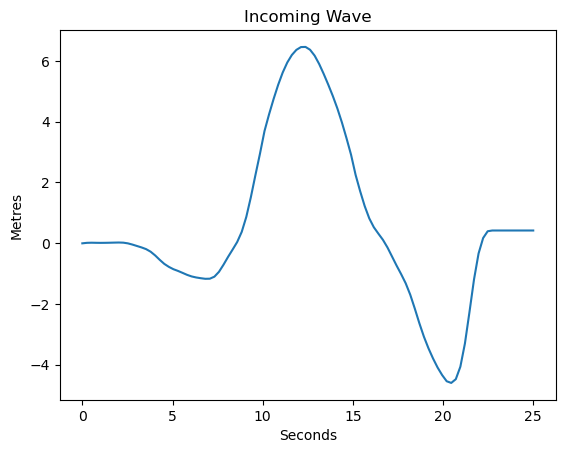

In [5]:
bdry = np.loadtxt(boundary_filename, skiprows=1)

bdry_t = bdry[:,0]
bdry_v = bdry[:,1]


import scipy.interpolate
wave_function = scipy.interpolate.interp1d(bdry_t, bdry_v, kind='zero', fill_value='extrapolate')

t = np.linspace(0.0,25.0, 100)

plt.plot(t,wave_function(t)*400);
plt.xlabel('Seconds')
plt.ylabel('Metres')
plt.title('Incoming Wave');

### Setup Domain

We define the `domain` for our simulation. This object encapsulates the mesh for our problem, which is defined by setting up a bounding polygon and associated tagged boundary. We use the `base_resolution` variable to set the maximum area of the triangles of our mesh.  

At the end we use `matplotlib` to visualise the mesh associated with the `domain`.

Number of Elements  2884
Figure files for each frame will be stored in _plot


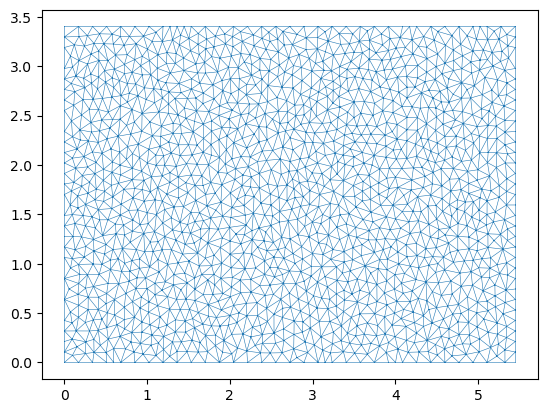

In [6]:
base_resolution = 0.01
#base_resolution = 0.0005

# Basic geometry and bounding polygon
xleft   = 0
xright  = 5.448
ybottom = 0
ytop    = 3.402

point_sw = [xleft, ybottom]
point_se = [xright, ybottom]
point_nw = [xleft, ytop]    
point_ne = [xright, ytop]

bounding_polygon = [point_se,
                    point_ne,
                    point_nw,
                    point_sw]

domain = anuga.create_domain_from_regions(bounding_polygon,
                                 boundary_tags={'wall': [0, 1, 3],
                                                'wave': [2]},     
                                 maximum_triangle_area=base_resolution,
                                 use_cache=False,
                                 verbose=False)


domain.set_name('okushiri')  # Name of output sww file 
domain.set_minimum_storable_height(0.001) # Don't store w-z < 0.001m
domain.set_flow_algorithm('DE1')

print ('Number of Elements ', domain.number_of_elements)


domain.set_plotter(min_depth=0.001)
domain.triplot(linewidth = 0.4);

### Setup Quantities

We use the `raster` created earlier to set the `quantity` called `elevation`.  We also set the  `stage` and the Mannings `friction`. 

We also visualise the `elevation` quantity.

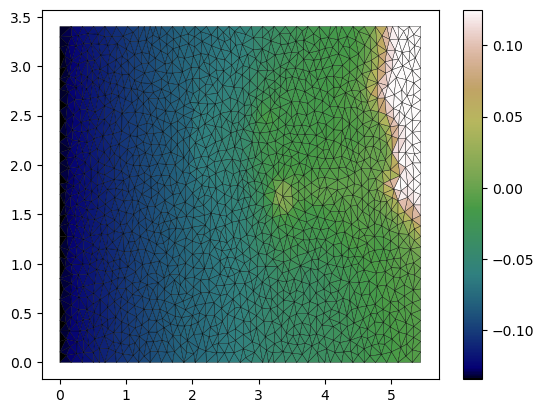

In [7]:
domain.set_quantity('elevation',raster=raster, location='centroids')
domain.set_quantity('stage', 0.0)
domain.set_quantity('friction', 0.0025)


domain.tripcolor(facecolors = domain.elev, 
                 edgecolors='k', 
                 cmap='gist_earth')
plt.colorbar();

### Setup Boundary Conditions

Excuse the verbose boundary type name `Transmissive_n_momentum_zero_t_momentum_set_stage_boundary`, but we use that to set the incoming wave boundary condition. 

On the other boundaries we will have just reflective boundaries.

In [8]:
Bts = anuga.Transmissive_n_momentum_zero_t_momentum_set_stage_boundary(domain, wave_function)

Br = anuga.Reflective_boundary(domain)

domain.set_boundary({'wave': Bts, 'wall': Br})

### Setup Interogation Variables

We will record the stage at the 3 gauge locations and at the Monai valley.

In [9]:
yieldstep = 0.5
finaltime = 25.0

nt = int(finaltime/yieldstep)+1


# area for gulleys
x1 = 4.85
x2 = 5.25
y1 = 2.05
y2 = 1.85

# indices in gulley area
x = domain.centroid_coordinates[:,0]
y = domain.centroid_coordinates[:,1]
v = np.sqrt( (x-x1)**2 + (y-y1)**2 ) + np.sqrt( (x-x2)**2 + (y-y2)**2 ) < 0.5


# Gauge and bounday locations
gauge = [[4.521, 1.196],  [4.521, 1.696],  [4.521, 2.196]] #Ch 5-7-9
bdyloc = [0.00001, 2.5]
g5_id = domain.get_triangle_containing_point(gauge[0])
g7_id = domain.get_triangle_containing_point(gauge[1])
g9_id = domain.get_triangle_containing_point(gauge[2])
bc_id = domain.get_triangle_containing_point(bdyloc)

# Arrays to store data
meanstage = np.nan*np.ones((nt,))
g5 = np.nan*np.ones((nt,))
g7 = np.nan*np.ones((nt,))
g9 = np.nan*np.ones((nt,))
bc = np.nan*np.ones((nt,)) 

### Evolve

In [10]:
stage_qoi = domain.stage[v]

k = 0
for t in domain.evolve(yieldstep=yieldstep, finaltime=finaltime):

    domain.print_timestepping_statistics()
    
    # stage
    stage_qoi = domain.stage[v]
    meanstage[k] = np.mean(stage_qoi)
    g5[k] = domain.stage[g5_id]
    g7[k] = domain.stage[g7_id]
    g9[k] = domain.stage[g9_id]
    bc[k] = domain.stage[bc_id]
    
    k = k+1
     
    #domain.save_depth_frame()


# Read in the png files stored during the evolve loop
#domain.make_depth_animation()

Time = 0.0000 (sec), steps=0 (28s)
Time = 0.5000 (sec), delta t in [0.01553114, 0.01553127] (s), steps=33 (0s)
Time = 1.0000 (sec), delta t in [0.01552392, 0.01553122] (s), steps=33 (0s)
Time = 1.5000 (sec), delta t in [0.01552381, 0.01552585] (s), steps=33 (0s)
Time = 2.0000 (sec), delta t in [0.01552456, 0.01552599] (s), steps=33 (0s)
Time = 2.5000 (sec), delta t in [0.01552109, 0.01552454] (s), steps=33 (0s)
Time = 3.0000 (sec), delta t in [0.01552098, 0.01553040] (s), steps=33 (0s)
Time = 3.5000 (sec), delta t in [0.01551921, 0.01553066] (s), steps=33 (0s)
Time = 4.0000 (sec), delta t in [0.01550540, 0.01551913] (s), steps=33 (0s)
Time = 4.5000 (sec), delta t in [0.01548068, 0.01550529] (s), steps=33 (0s)
Time = 5.0000 (sec), delta t in [0.01544420, 0.01548039] (s), steps=33 (0s)
Time = 5.5000 (sec), delta t in [0.01542374, 0.01544386] (s), steps=33 (0s)
Time = 6.0000 (sec), delta t in [0.01541583, 0.01542361] (s), steps=33 (0s)
Time = 6.5000 (sec), delta t in [0.01540816, 0.015415

### Animation Using swwfile

Read in the sww file and then iterate through the time slices to produce an animation.

In [11]:
swwplotter = anuga.SWW_plotter('okushiri.sww', min_depth = 0.001)

n = len(swwplotter.time)

for k in range(n):
  swwplotter.save_stage_frame(frame=k, vmin=-0.02, vmax = 0.1)
  
swwplotter.make_stage_animation()

Figure files for each frame will be stored in _plot


### View Time  Series

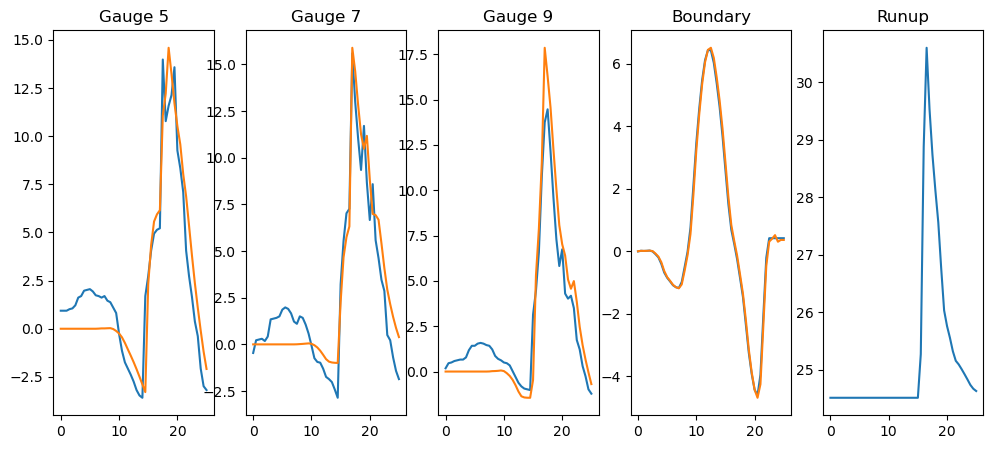

In [12]:
old_figsize = plt.rcParams['figure.figsize']

plt.rcParams['figure.figsize'] = [12, 5]

gauge = np.loadtxt(gauge_filename, skiprows=1)

gauge_t = gauge[:,0]
gauge_5 = gauge[:,1]
gauge_7 = gauge[:,2]
gauge_9 = gauge[:,3]

nt = int(finaltime/yieldstep)+1

import scipy
gauge_5_f = scipy.interpolate.interp1d(gauge_t, gauge_5, kind='zero', fill_value='extrapolate')
gauge_7_f = scipy.interpolate.interp1d(gauge_t, gauge_7, kind='zero', fill_value='extrapolate')
gauge_9_f = scipy.interpolate.interp1d(gauge_t, gauge_9, kind='zero', fill_value='extrapolate')

t = np.linspace(0.0,finaltime, nt)

tt= np.linspace(0.0,finaltime, nt)

plt.subplot(1,5,1)
plt.plot(t,gauge_5_f(t)*4)
plt.plot(tt,g5*400)
plt.title('Gauge 5')

plt.subplot(1,5,2)
plt.plot(t,gauge_7_f(t)*4)
plt.plot(tt,g7*400)
plt.title('Gauge 7')

plt.subplot(1,5,3)
plt.plot(t,gauge_9_f(t)*4)
plt.plot(tt,g9*400)
plt.title('Gauge 9')

plt.subplot(1,5,4)
plt.plot(t,wave_function(t)*400)
plt.plot(tt,bc*400)
plt.title('Boundary')
         
plt.subplot(1,5,5)
plt.plot(tt,meanstage*400)
plt.title('Runup');
         

plt.rcParams['figure.figsize'] = old_figsize